# Block DCT (Discrete Cosine Transform)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import frame
import block_DCT as DCT
import YCoCg as YUV
import cv2
import distortion
import os
import pylab
import information
import deadzone as Q

## Testing `block_DCT.analyze_block()` and `block_DCT.synthesize_block()`

In [ ]:
#a = np.random.randint(low=0, high=100, size=(4,4,3))
a = np.full(shape=(4,4,3), fill_value=10, dtype=np.int16)

In [ ]:
print(a)

In [ ]:
b = DCT.analyze_block(a)

In [ ]:
print(b.astype(np.int16))

In [ ]:
c = DCT.synthesize_block(b)

In [ ]:
print(c.astype(np.int16))

As it can be seen, the block is recovered.

## First ... some handy routines

In [ ]:
def __normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    #return 255*(img-min_component)/max_min_component
    return (img-min_component)/max_min_component

def __print_stats(frame):
    for i in range(frame.shape[2]):
        print("component", i, frame[..., i].max(), frame[..., i].min(), frame[..., i].dtype)

def __show_RGB_frame(frame, title=''):
    plt.figure(figsize=(16,16))
    plt.title(title, fontsize=20)
    plt.imshow(cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB))
    print_stats(frame)

def __show_frame(frame, title=''):
    plt.figure(figsize=(16,16))
    plt.title(title, fontsize=20)
    plt.imshow(frame)
    print_stats(frame)

## Testing `DCT.analyze_image()` and `DCT.synthesize_image()`

frame.read: ../sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
component 0 255 0 uint16
component 1 255 0 uint16
component 2 255 0 uint16


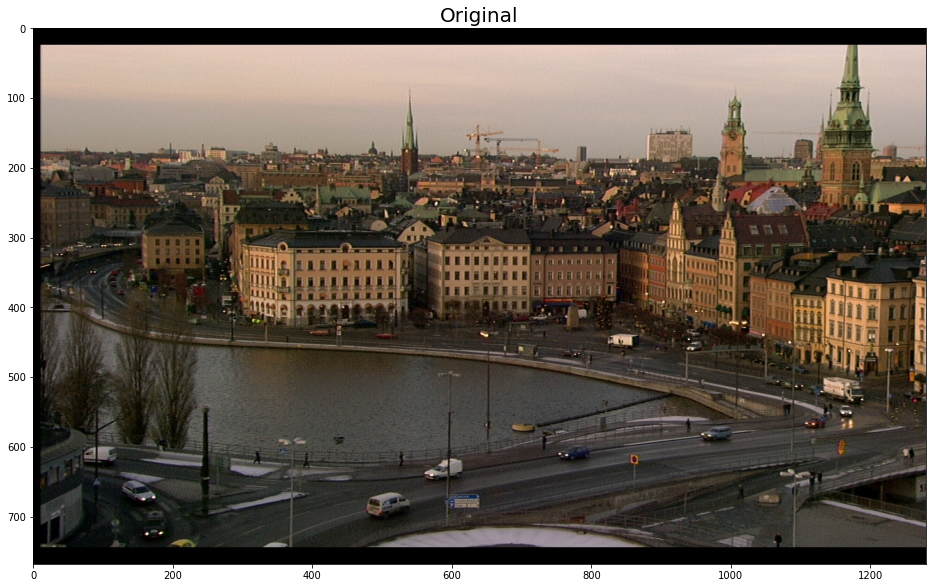

In [2]:
x = frame.read(f"../sequences/stockholm/", 0)
#show_frame(normalize(x))
frame.show_RGB_frame(x, title="Original")

In [ ]:
#x = YUV.from_RGB(x.astype(np.int16))
#show_frame(x)

In [ ]:
block_y_side = block_x_side = 8

In [ ]:
y = block_DCT.analyze(x, block_y_side, block_x_side)

In [ ]:
show_RGB_frame(255*normalize(y), "Block DCT domain")
show_RGB_frame(255*normalize(y[:64, :64]), "Block DCT domain (detail [0:64, 0:64])")

In [ ]:
z = block_DCT.synthesize(y, block_y_side, block_x_side)

In [ ]:
(x-z).max()

In [ ]:
r = x - z
show_RGB_frame(255*normalize(r), "Block DCT finite precission error")

In [ ]:
show_RGB_frame(z, "Reconstructed image")

## Switching between blocks and subbands

In [ ]:
block_y_side = block_x_side = 8
Q_step = 32
x = frame.read(f"../sequences/stockholm/", 0)
y = block_DCT.analyze(x, block_y_side, block_x_side)
q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, Q_step)
cor_dq_y = block_DCT.get_subbands(dq_y, block_y_side, block_x_side)

In [ ]:
show_RGB_frame(dq_y, "Decorrelated (original) dequantized block DCT domain")
show_RGB_frame(255*normalize(cor_dq_y), "Correlated dequantized block DCT domain")
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_frame(255*normalize(cor_dq_y[:blocks_in_y, :blocks_in_x]), f"L{block_y_side}L{block_x_side} subband detail")
show_RGB_frame(255*normalize(cor_dq_y[:blocks_in_y, blocks_in_x:2*blocks_in_x]), f"L{block_y_side}H{block_x_side-1} subband detail")
show_RGB_frame(255*normalize(cor_dq_y[blocks_in_y:2*blocks_in_y, :blocks_in_x]), f"L{block_y_side-1}H{block_x_side} subband detail")
show_RGB_frame(255*normalize(cor_dq_y[blocks_in_y:2*blocks_in_y, blocks_in_x:2*blocks_in_x]), f"L{block_y_side-1}H{block_x_side-1} subband detail")

In [ ]:
decor_dq_y = block_DCT.get_blocks(cor_dq_y, block_y_side, block_x_side)

In [ ]:
show_RGB_frame(decor_dq_y)

In [ ]:
(decor_dq_y == dq_y).all()

## Testing `block_DCT.constant_quantize()` and `block_DCT.constant_dequantize()`

In [ ]:
block_y_side = block_x_side = 64
q_step = 128
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, 128)
dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, 128)
dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)

In [ ]:
show_RGB_frame(np.clip(z, a_max=255, a_min=0), "Dequantized (in the block DCT domain and constant Q_step) image")

In [ ]:
r = x - z
n = normalize(r)
show_RGB_frame(255*n, "Quantization error")

## Coding subbands vs coding blocks
For simplicity, we will use constant quantization.

In [ ]:
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
print(x[...,0].max(),x[...,0].min())
print(x[...,1].max(),x[...,1].min())
print(x[...,2].max(),x[...,2].min())

disperse_RD_points = []
subband_RD_points = []
block_y_side = block_x_side = 8
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    # Notice that with constant_quantize() does not matter if the DCT domain
    # is organized in subbands or blocks.
    q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
    dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, Q_step)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    #frame.write(q_y, f"/tmp/{Q_step}_", 0)
    #_q_y = frame.read(f"/tmp/{Q_step}_", 0)
    #assert (q_y == _q_y).all() # <- This is false!!
    frame.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    _q_y = frame.read(f"/tmp/{Q_step}_", 0).astype(np.int32) - 32768
    #for _y in range(q_y.shape[0]):
    #    for _x in range(q_y.shape[1]):
    #        if q_y[_y, _x][..., 0] != _q_y[_y, _x][..., 0]:
    #            print(q_y[_y, _x], _q_y[_y, _x])
    #            break
    assert (q_y == _q_y).all()
    #print(q_y[...,0].max(), q_y[...,0].min())
    #print(q_y[...,1].max(), q_y[...,1].min())
    #print(q_y[...,2].max(), q_y[...,2].min())
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    disperse_RD_points.append((bits_per_pixel, MSE))
    subband_q_y = block_DCT.get_subbands(q_y, block_y_side, block_x_side)
    frame.write((subband_q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/s_{Q_step}_", 0)
    _subband_q_y = frame.read(f"/tmp/s_{Q_step}_", 0).astype(np.int32) - 32768
    assert (subband_q_y == _subband_q_y).all()
    bits_per_pixel = os.path.getsize(f"/tmp/s_{Q_step}_000.png")*8/x.size
    subband_RD_points.append((bits_per_pixel, MSE))
    print(Q_step, end=' ', flush=True)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*disperse_RD_points), label="disperse B-DCT")
pylab.plot(*zip(*subband_RD_points), label="subband B-DCT")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

## Can we do it better?
The performance of any image compressor depends on how much of the original information can be stored in the code-stream. In other words, the performance depends on the amount of distortion generated in the decoded image divided by the length of the code-stream. This is exactly what a operational R/D curve of the image represents.

The amount of distortion generated in the decoded image depends on the quantization. Because the DCT is a linear transform, the quantization error (that can be considered as a random signal added to the original image decreases its quality) generated by a quantizer is the same in the image and the transform domain. We will check that. Moreover, because the subbands generated by the DCT has the same gain (we will also check that), the constant quantization of all the subbands generates the same amount of distortion in all the subbands. Notice that the quantization error does not depends on the dynamic range of the signal, but only on the quantization step.

However, not always all the subbands are equally compressible. For example, if after a constant quantization all the coefficients of a subband become zero or very close to this value (because the energy of this subband is small compared to the quantization step), the cost of representing it in the code-stream will be low. Therefore, even if the contribution of this subband to the quality of the reconstructed image is small, the contribution of its representation can be significative.

An important question that arises here is: are the contribution of the subbands to the quality of the reconstructed image independent? If the transform is orthogonal (something that we will check), the answer is yes. Thanks to the contrubutions are independent, we can assume that the quantization error generated in one subband does not influence on the quantization error of the other subbands, and therefore, we can search in each subband, independently, the optimal quantization step that select the same slope in the operational R/D curve of the subband. Remember that each subband has the same gain (all the subbands generates the same quantization error for a constant quantization step) and that the transform is linear (the distortion can be measured equally in the image and the transform domain). Therefore, we can use the operational RD curves of the subbands that represents how the distortion of the subband decreases with the length of the code-stream of the subband. Thanks to this, we will not need to compute the inverse transform to measure the impact of quantization.

For the sake of simplicity, we will only suppose that the available quantization steps are [128, 64, 32, 16, 8, 4, 2 and 1]. Usually, this produces a operational RD curve whose points are equally distant (more or less) in the rate domain.

## Determination of the operational RD of each subband

In [ ]:
block_y_side = block_x_side = 4
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))
Q_steps = [128, 64, 32, 16, 8, 4, 2, 1]

# Create a list of lists. The first dimension is the subband and the second
# dimension is the point of the operational RD curve of the subband.
RD_points = []
RD_slopes = []
for i in range(block_y_side):
    for j in range(block_x_side):
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        subband_energy = distortion.average_energy(sb)
        # The first point of each RD curve has a maximum distortion equal
        # to the energy of the subband and a rate = 0
        RD_points.append([(0, subband_energy)])
        RD_slopes.append([])
        
# Now populate the rest of points of each subband
for i in range(block_y_side):
    for j in range(block_x_side):
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        counter = 0
        for Q_step in Q_steps:
            Q_indexes = Q.quantize(sb, Q_step)
            Q_coefs = Q.dequantize(Q_indexes, Q_step)
            MSE_Q_coefs = distortion.MSE(sb, Q_coefs)
            BPP_Q_indexes = information.PNG_BPP(Q_indexes)
            #BPP_Q_indexes = information.entropy(Q_indexes.astype(np.int16).flatten())
            RD_points[i * block_x_side + j].append((BPP_Q_indexes, MSE_Q_coefs))
            delta_BPP = BPP_Q_indexes - RD_points[i * block_x_side + j][counter][0]
            delta_MSE = RD_points[i * block_x_side + j][counter][1] - MSE_Q_coefs
            if delta_BPP > 0:
                slope = delta_MSE/delta_BPP
            else:
                slope = 0
            RD_slopes[i * block_x_side + j].append((Q_step, slope, (i, j)))
            counter += 1

In [ ]:
pylab.figure(dpi=150)
for i in range(block_y_side):
    for j in range(block_x_side):
        pylab.plot(*zip(*RD_points[i * block_x_side + j]), label=f"{i} {j}")
pylab.title("RD curves of the subbands")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
pylab.figure(dpi=150)
for i in range(block_y_side):
    for j in range(block_x_side):
        pylab.plot(*zip(*RD_points[i * block_x_side + j]), label=f"{i} {j}")
pylab.title("RD curves of the subbands")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.yscale("log")
plt.legend(loc="best")
pylab.show()

As it can be seen, the slope of all the subband is approximately the same, except for the subband (0, 0). This result sugests that the subband (0, 0) should be encoded first with Q_step=1 and then, use a constant quantization stage for the rest of subbands.

In [ ]:
subband = 0
Q_step_index = 0
RD_slopes[subband][Q_step][0:2]

In [ ]:
RD_slopes_without_sb_index = []
for i in range(block_y_side):
    for j in range(block_x_side):
        RD_slopes_without_sb_index.append([])
for i in range(block_y_side):
    for j in range(block_x_side):
        for Q_step in range(len(Q_steps)):
            #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
            RD_slopes_without_sb_index[i * block_x_side + j].append(RD_slopes[i * block_x_side + j][Q_step][0:2])

pylab.figure(dpi=150)
for i in range(block_y_side):
    for j in range(block_x_side):
        pylab.plot(*zip(*RD_slopes_without_sb_index[i * block_x_side + j]), label=f"{i} {j}")
pylab.title("RD curves of the subbands")
pylab.xlabel("Q_step")
pylab.ylabel("Slope")
plt.legend(loc="best")
pylab.show()

These results show that the subband that constributes the most to the quality of the reconstruction is [0, 0], followed by [0, 1] and [1, 0]. Let's sort the slopes.

In [ ]:
RD_slopes

In [ ]:
single_list = []
for i in range(block_y_side):
    for j in range(block_x_side):
        for Q_step in range(len(Q_steps)):
            #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
            single_list.append(tuple(RD_slopes[i * block_x_side + j][Q_step]))

In [ ]:
single_list

In [ ]:
sorted_slopes = sorted(single_list, key=lambda x: x[1])[::-1]

In [ ]:
sorted_slopes

These result shows that the constant quantization step is not optimal, but it's performance is not bad. Let's implement now the optimal quantization progression.

## Optimal quantization progression
Let's plot the optimal RD curve.

In [ ]:
y_prog = np.zeros_like(y_sbs)
for s in sorted_slopes:
    subband = s[2]
    i = subband[0]
    j = subband[1]
    Q_step = s[0]
    print(subband, Q_step)
    y_prog[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)] = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                                                    blocks_in_x*j:blocks_in_x*(j+1)]
    y_quant = Q.quantize(y_prog, Q_step)
    y_dequant = Q.dequantize(y_quant, Q_step)
    

## Computation of the RD slopes

In [ ]:
print(RD_points)

In [ ]:
for Q_step in range(len(Q_steps)):
    for i in range(block_y_side):
        for j in range(block_x_side):
            print(f"{RD_points[i * block_x_side + j][Q_step], end=' ')
    print()

In [ ]:
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        #zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

## Subband gains
The gain of each subband can be computed giving energy to a subband, performing the inverse transform, and measuring the energy of the reconstruction.

In [ ]:
block_y_side = block_x_side = 8
blocks_in_y = 1024//block_y_side
blocks_in_x = 1024//block_x_side
y_only_one_sb = np.empty(shape=(1024, 1024))
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb[...] = 0.0
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = 100.0
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        energy = distortion.average_energy(z_only_one_sb)
        print(int(energy), end=' ')
    print()

As it can be seen, the 8x8 DCT has (approximately) the same gain for all the subbands and therefore, the constant quantization is optimal from this point of view. Let's analyze now the information content of each subband.

## Dynamic range of the subbands
Some subbands (such as LL) has more energy than others. Notice, however, that energy is not equal to information.

In [ ]:
block_y_side = block_x_side = 8
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
max_, min_ = block_DCT.compute_max_min(y, block_y_side, block_x_side)

In [ ]:
np.set_printoptions(edgeitems=8, linewidth=120, formatter=dict(float=lambda x: "%.3g" % x))
print(max_.astype(np.int32))

In [ ]:
print(min_.astype(np.int32))

## Variances of the subbands
The variance in each subband, however, is a good estimator of the information provided the subband.

In [ ]:
block_y_side = block_x_side = 8
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
variances = block_DCT.compute_variances(y, block_y_side, block_x_side)

In [ ]:
np.set_printoptions(edgeitems=5, linewidth=100, formatter=dict(float=lambda x: "%.3g" % x))
print(variances.astype(np.int32))
print("max var =", variances.max(), "at", np.unravel_index(variances.argmax(), variances.shape))
print("min var =", variances.min(), "at", np.unravel_index(variances.argmin(), variances.shape))

As it can be seen, most of the information is stored in the low-frequency subbands.

## Quantizing depending on the variance
Lets quantize depending on the variance.

In [ ]:
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

variance_RD_points = []
block_y_side = block_x_side = 8
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    variances = np.sqrt(block_DCT.compute_variances(y, block_y_side, block_x_side))
    normalized_variances = (variances - variances.min()) / (variances.max() - variances.min())
    Q_steps = Q_step / np.log(normalized_variances + 1.01)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    #frame.write(q_y, f"/tmp/{Q_step}_", 0)
    frame.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    variance_RD_points.append((bits_per_pixel, MSE))
    print(Q_step)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*subband_RD_points), label="constant quantization")
pylab.plot(*zip(*variance_RD_points), label="variance-based quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

As it can be seen, varying the quantization step depending on the variance does not necessarily improves significatively the R/D tradeoff. This is a consequence of that the subband gains are approximately the same and therefore, the quantization noise remains constant among subbands.

## Quantizing depending on the variance with thresholding
Now, we set to zero all those quantization idexes that (in absolute value) are smaller than a threshold.

In [ ]:
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

threshold_RD_points = []
block_y_side = block_x_side = 8
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    variances = np.sqrt(block_DCT.compute_variances(y, block_y_side, block_x_side))
    normalized_variances = (variances - variances.min()) / (variances.max() - variances.min())
    Q_steps = Q_step / np.log(normalized_variances + 1.01)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    q_y[ abs(q_y) < 3] = 0 
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    #frame.write(q_y, f"/tmp/{Q_step}_", 0)
    frame.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    threshold_RD_points.append((bits_per_pixel, MSE))
    print(Q_step)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*subband_RD_points), label="constant quantization")
pylab.plot(*zip(*threshold_RD_points), label="variance-based quantization with threshold")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

And, as it can be seen, as it happens with a variable variance-based (wihtout thresholding) quantization step, the effect that we can reach lower bit-rates (obviously, increasing the distortion), although not better R/D tradeoffs.

## About the contribution of the subbands to the quality of the recostruction
Quantization can be also considered as a form of controlling how much information of the original image will be found in the reconstruction. Moreover, due to the DCT is orthogonal, DCT coefficients (and therefore, also the subbands) are uncorrelated, which implies that the contribution of each subband to the reconstruction is independent.

To check this we can:
1. Transform the image.
2. Generate the subbands.
3. Set to zero all the subband except one.
4. Restore the DCT-blocks.
5. Apply the inverse transform.
6. Transform the generated image.
7. Test if the resulting DCT image matches with DCT image used in the step 5. If matches (with some maximum error), the transform is orthogonal.

In [ ]:
block_y_side = block_x_side = 4
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side

i_coordinate_to_keep = 1
j_coordinate_to_keep = 1
mask = np.zeros_like(y, bool)
mask[blocks_in_y*i_coordinate_to_keep:(blocks_in_y+1)*i_coordinate_to_keep,
     blocks_in_x*j_coordinate_to_keep:(blocks_in_x+1)*j_coordinate_to_keep] = True
y_sbs[~mask] = 0
y_blks = DCT.get_blocks(y_sbs, block_y_side, block_x_side)
y_blks_copy = np.copy(y_blks)
z = DCT.synthesize(y_blks, block_y_side, block_x_side)
y2 = DCT.analyze(z, block_y_side, block_x_side)
print((y2 == y_blks_copy).all())
print((y2[~mask] == 0).all())

Therefore, the DCT is orthogonal.

## R/D performance

## Is the B-DCT orthogonal (and orthonormal)?
Orthogonality implies that the contributions of the distortion of the subbands to the distortion of the reconstructed image are additive. Orthonormality that the contributions are the same.

## Contribution of each subband to the distortion of the reconstruction
The DCT is orthogonal. This means that the DCT coefficients are uncorrelated, or in other words, that the quantization error generated in one coefficient (or subband) is not correlated with the quantization error generated in other coefficients (or subbands).

Following this reasoaning, we can assume that the quantization noise

We perform the inverse transform of the subband decomposition considering only one subband (zeroing the rest) and measuring the MSE between the reconstructed image and the original one.

In [ ]:
block_y_side = block_x_side = 8
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))
MSE_l = []
entropy_l = []
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        #zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

In [ ]:
print("Entropy:")
for i in range(block_y_side):
    for j in range(block_x_side):
        entropy = entropy_l[i*block_x_side+j]
        print(f"{entropy:7.2f}", end=' ')
    print()
print("MSE:")
for i in range(block_y_side):
    for j in range(block_x_side):
        MSE = MSE_l[i*block_x_side+j]
        print(f"{MSE:7.2f}", end=' ')
    print()
print("MSE improvement:")
for i in range(block_y_side):
    for j in range(block_x_side):
        improvement = image_energy - MSE_l[i*block_x_side+j]
        print(f"{improvement:7.2f}", end=' ')
    print()
print("Slope:")
for i in range(block_y_side):
    for j in range(block_x_side):
        slope = (image_energy - MSE_l[i*block_x_side+j]) / entropy_l[i*block_x_side+j]
        print(f"{slope:7.2f}", end=' ')
    print()

It can be seen that the subband LL and its neighborhood contribute more to the quality of the reconstruction (in terms of R/D) than the others. These differences depends on the correlation between the original image and the (2D) basis functions corresponding to each subband.

## 

## A manual search of the optimal sequence of quantization steps per subband
For the sake of simpliticy, let's suppose that only the quantization steps [128, 54, 32, 16, 8, 4, 2, 1] are available. We will work only with 16 subbands, for the same reason.

This creates a search tree of nodes where each one represents a relative , where there is sequence of nodes

In [ ]:
block_y_side = block_x_side = 4
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(image_energy)


### Considering only L4L4.Q=128

In [ ]:
i = 0
j = 0
Q_step = 128
MSEs_LL = []
entropies_LL = []
y_progressive = np.zeros_like(y_sbs)
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
slope = (image_energy - MSE) / entropy
print("Delta MSE =", MSE, "Delta Entropy =", entropy, "Slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

### After S[0, 0].Q=128, considering S[0, 0].Q=64

In [ ]:
i = 0
j = 0
Q_step = 64
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
delta_MSE = MSEs_LL[0] - MSE
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
delta_entropy = entropy - entropies_LL[0]
slope = delta_MSE / delta_entropy
print("Delta MSE =", delta_MSE, "Delta_entropy =", delta_entropy, "slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

### After S[0, 0].Q=128, considering S[0, 1].Q=128

In [ ]:
i = 0
j = 0
Q_step = 128
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
i = 0
j = 1
Q_step = 128
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
delta_MSE = MSEs_LL[0] - MSE
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
delta_entropy = entropy - entropies_LL[0]
slope = delta_MSE / delta_entropy
print("Delta MSE =", delta_MSE, "Delta_entropy =", delta_entropy, "slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

In [ ]:
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))
MSE_l = []
entropy_l = []
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

In [ ]:
block_y_side = block_x_side = 8
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side

print("Accumulated subband distortions:")
accum_RD_points = []
y_accum_sbs = np.zeros_like(y_sbs)
for i in range(block_y_side):
    for j in range(block_x_side):
        if i!=0 and j!=0:
            sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                       blocks_in_x*j:blocks_in_x*(j+1)]
            y_accum_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                        blocks_in_x*j:blocks_in_x*(j+1)] = sb
            y_accum_sbs_blks = DCT.get_blocks(y_accum_sbs, block_y_side, block_x_side)
            z_accum_sbs = DCT.synthesize(y_accum_sbs_blks, block_y_side, block_x_side)
            zz_accum_sbs = YUV.to_RGB(z_accum_sbs)
            MSE = distortion.MSE(xx, zz_accum_sbs)
            print(i, j, MSE)
            accum_RD_points.append((i*block_y_side+j, MSE))

In [ ]:
pylab.figure(dpi=150)
subband_index = np.arange(0, block_y_side*block_x_side, 0.01)
pylab.plot(subband_index, 1/subband_index, label="1/x")
pylab.plot(*zip(*accum_RD_points), label="optimal quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("subband index")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In the case of the B-DCT, all subbands have a similar gain. Therefore, al subbands should be quantized with the same quantization step.

## R/D optimization
The quantization steps should operate in each subband with the same RD-slope.

In [ ]:
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

optimal_RD_points = []
block_y_side = block_x_side = 8
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    #slopes = block_DCT.get_slopes(y, block_y_side, block_x_side, Q_step)
    Q_steps, slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_step)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    frame.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    optimal_RD_points.append((bits_per_pixel, MSE))
    print(Q_step, end=' ', flush=True)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*variance_RD_points), label="variance quantization")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

### A special situation

In [ ]:
special_RD_points = []
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
Q_steps = np.full(shape=(block_y_side, block_x_side), dtype=np.float32, fill_value=100000)
Q_steps[0, 0] = 128
q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
show_RGB_frame(255*normalize(YUV.to_RGB(q_y)), "Quantized subbands")
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_frame(255*normalize(YUV.to_RGB(q_y[:blocks_in_y, :blocks_in_x])), f"L{block_y_side}L{block_x_side} quantized subband detail")
dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
dq_zz = YUV.to_RGB(qd_z)
show_RGB_frame(255*normalize(dq_zz), "Reconstruction")
frame.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
MSE = distortion.MSE(xx, dq_zz)
special_RD_points.append((bits_per_pixel, MSE))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*variance_RD_points), label="variance quantization")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantization")
pylab.plot(*zip(*special_RD_points), label="special quantization", marker='o')
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
## Operational RD curve

In [ ]:
block_y_side = block_x_side = 4
xx = frame.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
for i in range(block_y_side):
    for j in range(block_x_side):
        subband = y[blocks_in_y*i:blocks_in_y*(i+1),
                    blocks_in_x*j:blocks_in_x*(j+1)][..., 0]
        RD_curve = []
        for Q_step in [128,64,32,16,8,4,2,1]:
            Q_subband = Q.quantize(subband, Q_step)
            d_Q_subband = Q.dequantize(Q_subband, Q_step)
            RD_point = (information.entropy(d_Q_subband.flatten().astype(np.int16)),
                       distortion.MSE(subband,d_Q_subband))
            RD_curve.append(RD_point)
            
        pylab.plot(*zip(*RD_curve), label='')
        pylab.title(f"{i} {j}")
        pylab.xlabel("bits/pixel")
        pylab.ylabel("MSE")
        plt.legend(loc="best")
        pylab.show()

In [ ]:
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_frame(255*normalize(cor_dq_y[:blocks_in_y, :blocks_in_x]), f"L{block_y_side}L{block_x_side} subband detail")
show_RGB_frame(255*normalize(cor_dq_y[:blocks_in_y, blocks_in_x:2*blocks_in_x]), f"L{block_y_side}H{block_x_side-1} subband detail")
show_RGB_frame(255*normalize(cor_dq_y[blocks_in_y:2*blocks_in_y, :blocks_in_x]), f"L{block_y_side-1}H{block_x_side} subband detail")


In [ ]:
block_y_side = block_x_side = 256
q_step = 128
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
variances = block_DCT.compute_variances(y, block_y_side, block_x_side)
print(variances.max(), np.unravel_index(variances.argmax(), variances.shape))

## Testing `block_DCT.find_optimal_Q_steps()`

In [ ]:
block_y_side = block_x_side = 64
q_step = 16
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
print(block_DCT.compute_slopes(y, block_y_side, block_x_side, Q_step).astype(np.int32))

In [ ]:
Q_steps, slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_step)

In [ ]:
print(Q_steps, slopes.astype(np.int32))

In [ ]:
q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)

In [ ]:
show_RGB_frame(np.clip(z, a_max=255, a_min=0), "Dequantized (using optimal quantization steps) image")

## Computing the variance of the DCT coefficients

In [ ]:
block_y_side = block_x_side = 64
y = block_DCT.analyze(x, block_y_side, block_x_side)
q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, 128)
v = block_DCT.compute_variances(q_y, block_y_side, block_x_side)

In [ ]:
print(v)

## Quantizing the YCoCg/B-DCT domain

### Using constant quantization

### Using "optimal" quantization

In [ ]:
xx = frame.read(f"../sequences/stockholm/", 0)
x = YUV.from_RGB(xx.astype(np.int16))

constant_RD_points = []
optimal_RD_points = []
block_y_side = block_x_side = 128
for Q_step in [128,64,32,16,8,4,2,1]:
    print(Q_step, end=' ', flush=True)
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    
    # Constant quantization
    q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
    dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, Q_step)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    frame.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    constant_RD_points.append((bits_per_pixel, MSE))

    # Optimal quantization
    slopes, Q_steps = block_DCT.get_slopes(y, block_y_side, block_x_side, Q_step)
    target_slope = np.median(slopes)
    Q_steps, new_slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_steps, slopes, target_slope)
    print(f"current={slopes.astype(np.int16)}\ntarget_slope={target_slope}\nnew={new_slopes.astype(np.int16)}\nQ_steps={Q_steps}")
    print(slopes.max(), slopes.min())
    print(new_slopes.max(), new_slopes.min())
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    frame.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    optimal_RD_points.append((bits_per_pixel, MSE))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*constant_RD_points), label="constant quantized B-DCT")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantized B-DCT")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
Q_steps

In [ ]:
slopes

In [ ]:
new_slopes